In [ ]:
import os
import pickle
from typing import Callable

import numpy as np
from numba import njit
import sympy as sp



from utils.core import(
    bound_critical_parameter,
    locate_critical_parameter,
    bruteforce_parameter_and_energy_relationship,
)

from utils.utilities import (
    geospace,
    get_secant_function,
    get_ODE_function,
    y_vacuum,
)

from utils.methods import trapezoid, rk4


from matplotlib import pyplot as plt
import utils.plot as plot_utils
from utils.plot import draw_horizons, blend_color
from matplotlib import colors as mcolors




lighter_blue = blend_color("blue", 0.3, background="white")
lighter_red = blend_color("red", 0.3, background="white")

In [ ]:
### SPECIFY PARAMETERS

# Runge-Kutta parameters
R_MIN = 1.0
R_MAX = 2000.0
STEP = -0.05

# secant method parameters
SECANT_TOLERANCE = 1e-8
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6


# critical parameter in the parameter space

MAX_ITERS = 20
ALPHA_MAX = 300 # ad hoc, could be arbirtrarily large
ALPHA_MIN = 0

# locate critical parameter value using binary search

BISECTION_TOLERANCE = 1e-11
BISECTION_MAX_ITERS = 20
BISECTION_ROOT_TOLERANCE = 1e-3

# brutefore parameter range setup
COUNT = 100
OFFSET = 50
RATIO = 0.9

# density profile

RADIUS = 500
SIGMA = 25

shell = "gauss"

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    sigma = SIGMA
    radius = RADIUS

    @njit
    def _rho(x: float) -> float:
            return amplitude * np.exp(-0.5 * (x - radius)**2 / (sigma**2))
    return _rho

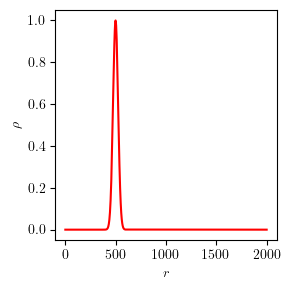

In [3]:
# plot the density profile

unit_rho = get_rho(1)
r_vals = np.arange(R_MAX, R_MIN + STEP, STEP)
unit_rho_vals = [unit_rho(_r) for _r in r_vals]\

plt.figure(figsize=(3, 3))
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.plot(r_vals, unit_rho_vals, color="red")
plt.tight_layout()
plt.show()

In [4]:
forced = False # if True, the code will always run the brute-force search and save results to a file


if not forced and (os.path.isfile("data/" +  shell + "_critical.pkl")):
    with open("data/" +  shell + "_critical.pkl", "rb") as f:
        results = pickle.load(f)

    critical_alpha = results["critical_alpha"]
    critical_parameter = results["critical_parameter"]

else:
    ((parameter_lower, parameter_upper), (alpha_lower, alpha_upper), boolean_success) = bound_critical_parameter(
        _get_rho = get_rho,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        parameter_max = None,
        alpha_max = ALPHA_MAX,
        alpha_min = ALPHA_MIN,
        max_iters = MAX_ITERS,
        minimal_seeked_bound_distance = 1e-3,
        verbose = True,
        scale = 2,
    )

    critical_alpha, critical_parameter, _ = locate_critical_parameter(
        _get_rho = get_rho,
        start = parameter_lower,
        end = parameter_upper,
        alpha_start = alpha_lower,
        alpha_end = alpha_upper,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        bisection_tolerance = BISECTION_TOLERANCE,
        bisection_max_iters = BISECTION_MAX_ITERS,
        bisection_root_tol = BISECTION_ROOT_TOLERANCE
    )

    with open("data/" +  shell + "_critical.pkl", "wb") as f:
        pickle.dump(
            {
                "critical_alpha": critical_alpha,
                "critical_parameter": critical_parameter,
            },
            f,
    )

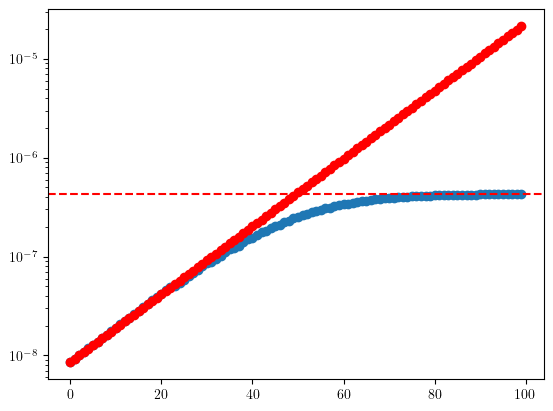

In [5]:
geometric = geospace(critical_parameter / OFFSET, critical_parameter, steps = (COUNT // 2)+1, ratio=RATIO)
logarithmic = np.logspace(np.log10(critical_parameter / OFFSET), np.log10(critical_parameter), COUNT // 2, base=10.0)

parameters = np.sort(np.concatenate((geometric, logarithmic)))[1:] # join, sort and remove first duplicit value
scaled_parameters = np.logspace(np.log10(critical_parameter / OFFSET), np.log10(critical_parameter * OFFSET), COUNT, base=10.0)


plt.scatter(range(len(parameters)), parameters)
plt.scatter(range(len(scaled_parameters)), scaled_parameters, color="red", label="scaled parameters")
plt.axhline(critical_parameter, color="red", linestyle="--", label="critical parameter")
plt.yscale("log")
plt.show()

In [6]:
# ∇ Ψ + 2πρ Ψ^exponent = 0
exponent = 0 # for scaling
parameter_search_range = parameters.copy()
parameter_search_range_scaled = scaled_parameters.copy()
alpha_search_range = np.linspace(0, 5000, 20) # starting guesses, ad hoc, could be arbirtrarily large

In [7]:
forced = False # if True, the code will always run the brute-force search and save results to a file

if not forced and (os.path.isfile("data/" + shell + "_results.pkl") and os.path.isfile("data/" + shell + "_results_scaled.pkl")):
    with open("data/" + shell + "_results.pkl", "rb") as f:
        results = pickle.load(f)

    ADM_mass_vals = results["E_ADM"]
    rest_mass_vals = results["rest_mass"]
    parameters = results["parameters"]
    horizons = results["horizons"]

    with open("data/" + shell + "_results_scaled.pkl", "rb") as f:
        results_scaled = pickle.load(f)

    ADM_mass_vals_scaled = results_scaled["E_ADM"]
    rest_mass_vals_scaled = results_scaled["rest_mass"]
    parameters_scaled = results_scaled["parameters"]
    horizons_scaled = results_scaled["horizons"]
else:

    ADM_mass_vals, rest_mass_vals, parameters, horizons = bruteforce_parameter_and_energy_relationship(
        get_rho,
        parameter_search_range,
        alpha_search_range,
        (R_MAX, R_MIN, STEP),
        (SECANT_TOLERANCE, SECANT_MAX_ITERS, SECANT_INITIAL_STEP),
        exponent = 5,
        unique_root_tolerance=1e-4,
    )

    ADM_mass_vals_scaled, rest_mass_vals_scaled, parameters_scaled, horizons_scaled = bruteforce_parameter_and_energy_relationship(
        get_rho,
        parameter_search_range_scaled,
        alpha_search_range,
        (R_MAX, R_MIN, STEP),
        (SECANT_TOLERANCE, SECANT_MAX_ITERS, SECANT_INITIAL_STEP),
        exponent = exponent,
        unique_root_tolerance=1e-4,
    )

    # save results to a file

    with open("data/" + shell + "_results.pkl", "wb") as f:
        pickle.dump(
            {
                "E_ADM": ADM_mass_vals,
                "rest_mass": rest_mass_vals,
                "parameters": parameters,
                "horizons": horizons,
            },
            f,
        )
    with open("data/" + shell + "_results_scaled.pkl", "wb") as f:
        pickle.dump(
        {
            "E_ADM": ADM_mass_vals_scaled,
            "rest_mass": rest_mass_vals_scaled,
            "parameters": parameters_scaled,
            "horizons": horizons_scaled,
        },
        f,
    )
    

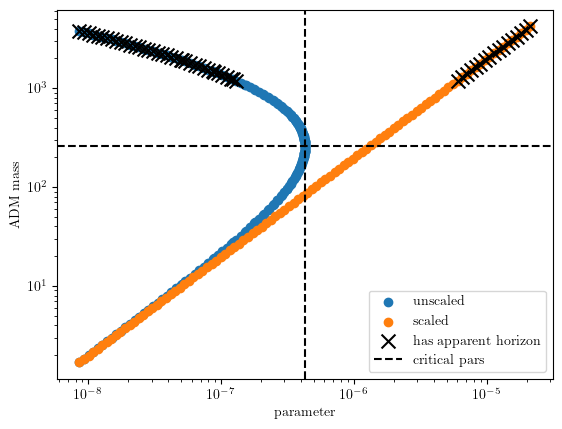

In [8]:
### plot bruteforce results

h_pars = [val[0] for val in horizons]
h_pars_scaled = [val[0] for val in horizons_scaled]
h_ADM = [val[1] for val in horizons]
h_ADM_scaled = [val[1] for val in horizons_scaled]

plt.ylabel("ADM mass")
plt.xlabel("parameter")

plt.scatter(parameters, ADM_mass_vals, label="unscaled")
plt.scatter(parameters_scaled, ADM_mass_vals_scaled, label="scaled")

plt.scatter(h_pars_scaled, h_ADM_scaled, label="has apparent horizon", color = "black", marker="x", s=100)
plt.scatter(h_pars, h_ADM, color = "black", marker="x", s=100)   

plt.axvline(x=critical_parameter, color="black", linestyle="--", label="critical pars")
plt.axhline(y=2*critical_alpha, color="black", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [9]:
mixed_parameters = np.concatenate((parameters, parameters_scaled))
mixed_parameters = np.sort(np.unique(mixed_parameters))

In [10]:
critical_index = np.argmin(np.abs(np.array(mixed_parameters) - critical_parameter))

param_start = min(mixed_parameters)
param_end = max(mixed_parameters)
count = len(mixed_parameters)

In [ ]:
_parameters = np.array([parameters[i] for i in np.argsort(ADM_mass_vals)])
_rest_mass_vals = np.array([rest_mass_vals[i] for i in np.argsort(ADM_mass_vals)])
_ADM_mass_vals = np.array([ADM_mass_vals[i] for i in np.argsort(ADM_mass_vals)])

_parameters_scaled = np.array([parameters_scaled[i] for i in np.argsort(ADM_mass_vals_scaled)])
_rest_mass_vals_scaled = np.array([rest_mass_vals_scaled[i] for i in np.argsort(ADM_mass_vals_scaled)])
_ADM_mass_vals_scaled = np.array([ADM_mass_vals_scaled[i] for i in np.argsort(ADM_mass_vals_scaled)])

critical_index = np.argmin(np.abs(np.array(_parameters) - critical_parameter))

lower_branch_ADM_mass = _ADM_mass_vals[:critical_index + 1]
lower_branch_rest_mass = _rest_mass_vals[:critical_index + 1]
lower_branch_parameters = _parameters[:critical_index + 1]

upper_branch_ADM_mass = _ADM_mass_vals[critical_index:]
upper_branch_rest_mass = _rest_mass_vals[critical_index:]
upper_branch_parameters = _parameters[critical_index:]

horizon_parameters = [val[0] for val in horizons]
horizon_ADM_mass = [val[1] for val in horizons]
horizon_rest_mass = [val[2] for val in horizons]

horizons_start_at_parameter = np.max(horizon_parameters)

# separate those values with horizons and those without

upper_branch_parameters_with_horizons = [par for par in upper_branch_parameters if par <= horizons_start_at_parameter]
upper_branch_ADM_mass_with_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]
upper_branch_rest_mass_with_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]

upper_branch_without_horizons = [par for par in upper_branch_parameters if par >= horizons_start_at_parameter]
upper_branch_ADM_mass_without_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]
upper_branch_rest_mass_without_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]

first horizon found at approx. parameter 1.3e-07 with ADM energy 1.2e+03 and rest mass 2.6e+03


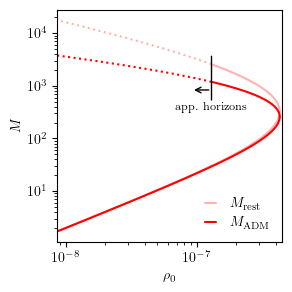

In [13]:
scale = 0.4
width = 3.02419  #plot_utils.textwidth * scale * plot_utils.cm_to_inch
height = 3.02419 # width

color = "red"
lighter_color = blend_color(color, 0.3)

fig = plt.figure(figsize=(width, height), tight_layout=True)

draw_horizons(horizons, exponent = 5, delta=0.6, arrow_length=0.6)

plt.plot(lower_branch_parameters, lower_branch_rest_mass, color=lighter_color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_rest_mass_without_horizons, color=lighter_color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{rest}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_rest_mass_with_horizons, color=lighter_color, linewidth=1.5, linestyle="dotted")

plt.plot(lower_branch_parameters, lower_branch_ADM_mass, color=color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_ADM_mass_without_horizons, color=color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{ADM}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_ADM_mass_with_horizons, color=color, linewidth=1.5, linestyle="dotted")

plt.xlim(left=min(parameters))

plt.xscale("log")
plt.yscale("log")

plt.minorticks_on()

plt.ylabel(r"$M$")
plt.xlabel(r"$\rho_0$")

plt.legend(
    loc="lower right", fancybox=False, 
    framealpha=1, frameon=False, ncol=1, handlelength=0.8, handletextpad=1, columnspacing=0.8, 
)
plt.savefig("img/" + shell + "_sol_curve.pdf", bbox_inches="tight", dpi=300)

first horizon found at approx. parameter 1.3e-07 with ADM energy 1.2e+03 and rest mass 2.6e+03
first horizon found at approx. parameter 6e-06 with ADM energy 1.2e+03 and rest mass 2.6e+03


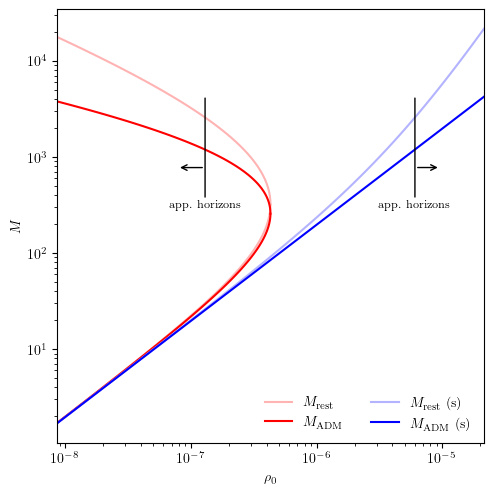

In [ ]:
cm = 1/2.54
golden_ratio = (np.sqrt(5) - 1) / 2
scale = 0.8
width = scale * 16 * cm
height = width

fig = plt.figure(figsize=(width, height), tight_layout=True)


# critical params

# plt.axvline(
#     x = critical_parameter, color="black", linestyle="dotted", alpha=1, linewidth=1,
# )

# plt.axhline(
#     y = 2 * critical_alpha, color="black", linestyle="dotted", alpha=1, linewidth=1
# )


# unscaled


plt.plot(
    _parameters[: critical_index + 1], _rest_mass_vals[: critical_index + 1],
    color=lighter_red,
    label=r"$M_{\text{rest}}$",
)

plt.plot(
    _parameters[critical_index:], _rest_mass_vals[critical_index:],
    color=lighter_red
)

plt.plot(
    _parameters[: critical_index + 1], _ADM_mass_vals[: critical_index + 1],
    color="red",
    label=r"$M_{\text{ADM}}$",
)

plt.plot(
    _parameters[critical_index:], _ADM_mass_vals[critical_index:],
    color="red",
)


draw_horizons(horizons, exponent = 5, delta=0.7, arrow_length=0.8)


# scaled

plt.plot(
    _parameters_scaled[critical_index:], _rest_mass_vals_scaled[critical_index:],
    color=lighter_blue
)


plt.plot(
    _parameters_scaled[: critical_index + 1], _rest_mass_vals_scaled[: critical_index + 1],
    color=lighter_blue,
    label=r"$M_{\text{rest}}$  (s)",
)


plt.plot(
    _parameters_scaled[: critical_index + 1], _ADM_mass_vals_scaled[: critical_index + 1],
    color="blue",
    label=r"$M_{\text{ADM}}$ (s)",
)

plt.plot(
    _parameters_scaled[critical_index:], _ADM_mass_vals_scaled[critical_index:],
    color="blue",
)

draw_horizons(horizons_scaled, exponent, delta=0.7, arrow_length=1.2)

plt.xscale("log")
plt.yscale("log")

plt.xlim(left = np.min(_parameters_scaled), right=np.max(_parameters_scaled))

plt.legend(
    loc="lower right", fancybox=False, 
    framealpha=1, frameon=False, ncol=2,
)

plt.minorticks_on()

plt.xlabel(r"$\rho_0$")
plt.ylabel(r"$M$")


plt.tight_layout()
plt.savefig("img/" + shell + "scaled_sol_curve.pdf", dpi=300, bbox_inches='tight')

In [ ]:
r_vals = []
psi_vals = []
dpsi_vals = []

for m, p in zip(horizon_ADM_mass, horizon_parameters):
    rho = get_rho(p)
    ode = get_ODE_function(get_rho(p), exponent=5)
    x, y = rk4(ode, R_MAX, y_vacuum(m/2, R_MAX), R_MIN, STEP)
    r_vals.append(x)
    psi_vals.append(y[:,0])
    dpsi_vals.append(y[:,1])

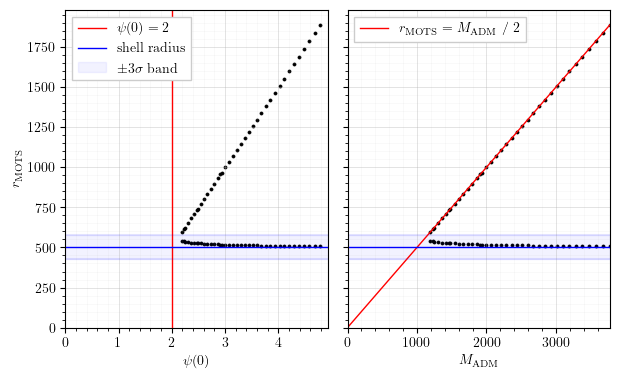

In [ ]:
cm = 1/2.54
golden_ratio = (np.sqrt(5) - 1) / 2

width = 16 * cm
height = width * golden_ratio

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(width, height), sharey=True)


# horizon_radii = []
for _r_vals, _psi_vals, _dpsi_vals, _adm, _par in zip(r_vals, psi_vals, dpsi_vals, horizon_ADM_mass, horizon_parameters):
    _f = np.array([_dpsi + _psi / (2 * _r) for _dpsi, _psi, _r in zip(_dpsi_vals, _psi_vals, _r_vals)])
    
    for i in range(len(_f) - 1):
        if _f[i] * _f[i + 1] < 0:
            # radius = 0.5 * (_r_vals[i] + _r_vals[i+1])
            radius = _r_vals[i] + _f[i] * (_r_vals[i + 1] - _r_vals[i]) / (_f[i + 1] - _f[i])
            
            ax1.scatter(
                _psi_vals[-1], radius, marker=".", color="black", s=20, linewidth=0.5
            ) 

            ax2.scatter(
                _adm, radius, marker=".", color="black", s=20, linewidth=0.5
            ) 

ax1.axvline(x = 2, color="red", linestyle="solid", alpha=1, linewidth=1,
    label = r"$\psi(0) = 2$",
)
# # plot a line radius = _adm / 2
ax2.plot(
    [0, max(horizon_ADM_mass)], [0, max(horizon_ADM_mass) / 2], color="red", linestyle="solid",
    label=r"$r_{\text{MOTS}} = M_{\text{ADM}}\,\, /\,\, 2$", alpha=1, linewidth=1
)

ax1.set_ylabel(r"$r_{\text{MOTS}}$")
ax1.set_xlabel(r"$\psi(0)$")
ax2.set_xlabel(r"$M_{\text{ADM}}$")
ax1.set_ylim(bottom=0)

ax2.set_xlim(left=0, right=max(horizon_ADM_mass))
ax1.set_xlim(left=0)


ax1.axhline(y=RADIUS, color="blue", linestyle="solid", linewidth=1, label = r"shell radius")
ax1.axhline(y=RADIUS - 3 * SIGMA, color="blue", linestyle="solid", alpha=0.1)
ax1.axhline(y=RADIUS + 3 * SIGMA, color="blue", linestyle="solid", alpha=0.1)

ax1.fill_betweenx(
    [RADIUS - 3 * SIGMA, RADIUS + 3 * SIGMA],
    0, max(horizon_ADM_mass), color="blue", alpha=0.05, label=r"$\pm 3\sigma$ band"
)

ax2.axhline(y=RADIUS, color="blue", linestyle="solid", linewidth=1)
ax2.axhline(y=RADIUS - 3 * SIGMA, color="blue", linestyle="solid", alpha=0.1)
ax2.axhline(y=RADIUS + 3 * SIGMA, color="blue", linestyle="solid", alpha=0.1)

ax2.fill_betweenx(
    [RADIUS - 3 * SIGMA, RADIUS + 3 * SIGMA],
    0, max(horizon_ADM_mass), color="blue", alpha=0.05
)


ax1.legend(loc="upper left", fancybox=False, framealpha=1, frameon=True)
ax2.legend(loc="best", fancybox=False, framealpha=1, frameon=True)


ax1.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
ax1.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax1.minorticks_on()

ax2.grid(True, linestyle="-", linewidth=0.5, alpha=0.5, which='major')
ax2.grid(True, linestyle="-", linewidth=0.5, alpha=0.1, which='minor')
ax2.minorticks_on()

plt.tight_layout()
plt.savefig("img/" + shell + "_horizons.pdf", dpi=300, bbox_inches='tight')


# plt.xlim(left=0, right=max(horizon_ADM_mass))
# plt.ylim(bottom=0)

In [ ]:
# calculate bounds on parameter space

all_lower = []
all_upper = []
all_params = []
all_R = [0.32 * R_MAX, 0.5 * R_MAX, R_MAX] # np.linspace(RADIUS + 5 * SIGMA, RK_START, 5, endpoint=True)

for R in all_R:
    lower = []
    upper = []
    params = []

    r_vals = np.arange(R, R_MIN + STEP, STEP)
    unit_rho = get_rho(1) #UNIT AMPLITUDE
    unit_rho_vals = [unit_rho(_r) for _r in r_vals]
    integral = trapezoid(r_vals, [_rho_r * _r**2 for _r, _rho_r in zip(r_vals, unit_rho_vals)]) 
    APPROX_AMPLITUDE_UPPER_BOUND = 1/(2*np.pi) * 4**4/5**5 * R / integral # assuming that shell is inside sphere B(0, R_MAX)
    
    print(f"Upper bound for amplitude is approximately: {APPROX_AMPLITUDE_UPPER_BOUND}")

    for selected_par in np.linspace(mixed_parameters[0], APPROX_AMPLITUDE_UPPER_BOUND, 50):

        rho = get_rho(selected_par)

        ode_unscaled = get_ODE_function(rho, exponent=5)
        sec_unscaled = get_secant_function(rho, R, R_MIN, STEP, exponent=5)

        r_vals = np.arange(R, R_MIN + STEP, STEP) # [0, R]
        rho_vals = [rho(r) for r in r_vals]
        integrand = [rho * r**2 for r, rho in zip(r_vals, rho_vals)]
        integral_result = trapezoid(r_vals, integrand)

        _a = integral_result
        _b = 1/(2*R)

        print(f"integral_result = {integral_result}")

        x, a, b = sp.symbols('x a b')
        poly = sp.Poly(a*(1+b*x)**5 - x, x)

        substituded_coeffs = np.array([coeff.subs({a: _a, b: _b}) for coeff in poly.all_coeffs()])


        #all_roots = mpmath.polyroots(substituded_coeffs, maxsteps=50, cleanup=True, extraprec=15)
        all_roots = np.roots(substituded_coeffs)


        real_roots = all_roots[np.isreal(all_roots)].real
        real_roots = np.sort(real_roots)	
        print(f"real roots: {real_roots}")

        real_roots = real_roots[real_roots > 0]
        print(f"positive real roots: {real_roots}")

        if len(real_roots) == 0:
            print("No positive real roots found")

        if len(real_roots) == 2:
            max_ADM_mass = max(real_roots)
            min_ADM_mass = min(real_roots)
            lower.append(min_ADM_mass)
            upper.append(max_ADM_mass)
            params.append(selected_par)

        # test if roots

        for root in real_roots:
            print(f"root = {root}, poly(root) = ", poly.subs({a: _a, b: _b, x: root}))

        print(f"-> valid ADM mass is bounded by {min_ADM_mass} and {max_ADM_mass}")

    all_lower.append(lower)
    all_upper.append(upper)
    all_params.append(params)

Upper bound for amplitude is approximately: 5.312963686253164e-07
integral_result = 0.13435825302649182
real roots: [-1.42273870e+04  1.34428821e-01  1.10232202e+04]
positive real roots: [1.34428821e-01 1.10232202e+04]
root = 0.1344288210565931, poly(root) =  -2.77555756156289e-17
root = 11023.220185377344, poly(root) =  5.45696821063757e-12
-> valid ADM mass is bounded by 0.1344288210565931 and 11023.220185377344
integral_result = 0.3019081392989433
real roots: [-1.19065471e+04  3.02264777e-01  8.70024796e+03]
positive real roots: [3.02264777e-01 8.70024796e+03]
root = 0.3022647772126715, poly(root) =  1.11022302462516e-16
root = 8700.247957144342, poly(root) =  -1.27329258248210e-11
-> valid ADM mass is bounded by 0.3022647772126715 and 8700.247957144342
integral_result = 0.46945802557138555
real roots: [-1.08250071e+04  4.70321144e-01  7.61710202e+03]
positive real roots: [4.70321144e-01 7.61710202e+03]
root = 0.4703211441386669, poly(root) =  0
root = 7617.102021119998, poly(root) 

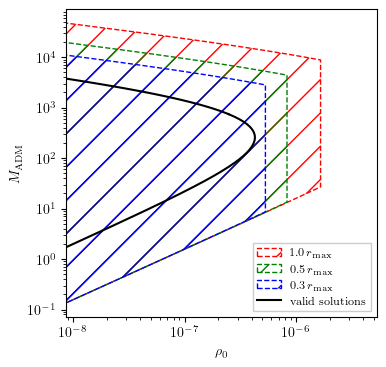

In [ ]:
cm = 1/2.54
golden_ratio = (np.sqrt(5) - 1) / 2

scale = 0.6
width = scale * 16 * cm
height = width * 1.05

plt.figure(figsize=(height, width), tight_layout=True)
plt.yscale("log")
plt.xscale("log")

colors = ["red", "green", "blue"]

i = 0
for lower, upper, params, R in zip(all_lower[::-1], all_upper[::-1], all_params[::-1], all_R[::-1]):
    # plt.plot(params, lower, color=colors[i])
    # plt.plot(params, upper, color=colors[i])
    #plt.plot([params[-1], params[-1]], [lower[-1], upper[-1]],color=colors[i], alpha=0.5)
    plt.fill_between(params, lower, upper, where=(np.array(lower) < np.array(upper)), alpha=1.0, 
                    fc="none", hatch="/", ec=colors[i], ls="--", label = (f"{R/R_MAX:.1f}" + r"$\,r_{\text{max}}$")
    )
    i += 1




plt.plot(
    _parameters[: critical_index + 1], _ADM_mass_vals[: critical_index + 1],
    color="black",
     label=f"valid solutions",
)

plt.plot(
    _parameters[critical_index:], _ADM_mass_vals[critical_index:],
    color="black",
)


plt.yscale("log")
plt.xscale("log")
plt.xlim(mixed_parameters[0], params[-1]*10)
# plt.ylim(top = upper[0]*10, bottom=lower[0]/3)

plt.xlabel(r"$\rho_0$")
plt.ylabel(r"$M_{\text{ADM}}$")

plt.legend(loc="lower right", fontsize="small", fancybox=False, ncol=1,
    framealpha=1, frameon=True,
)
plt.savefig("img/" + shell + "_bounds.pdf", dpi=300, bbox_inches='tight')